In [1]:
import warnings
import hazm
import re
import time
import ast
import random
import pandas as pd

from hazm import stopwords_list
from hazm import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from cleantext import clean

from tqdm import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from wordcloud_fa import WordCloudFa

from stopwords_guilannlp import stopwords_output

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
tqdm.pandas()

# Data Reading

In [3]:
base_path = "../data/"

input_file = base_path + "remote_tweets.csv"
emojies_file = base_path + "emojies.txt"

In [4]:
contextual_cols = ['tweet', 'hashtags']
tweets_df = pd.read_csv(input_file, low_memory=False, usecols=contextual_cols)
tweets_df.head(20)

,tweet,hashtags
0,به من گزارش میده حقوقش میدونم سالی ۸۵تا، همسرش...,NaN
1,اینایی که رفتن سفر، مهمونی و... هیچ پروتکلی هم...,NaN
2,دارم فکر میکنم که چقدر خسته ام با اینکه امروز ...,NaN
3,یک سال و نیمه از قبل آبان ۹۸ دورکار شدم تا الان,NaN
4,@shahrzaad حتمن میرفتم به شهری که به اقوام یا ...,NaN
5,دورکاری یا کار از خونه خیلی برام فرسایشی شده د...,NaN
6,@ehsan_bz تو بخش‌های دیگه نمی‌دونم ولی بخش فنی...,NaN
7,@Klaus5566 @sara90059240 مای بدبخت هیچوقت دورک...,NaN
8,@JabbariForouq @Steppenwolf1989 اخه مشکل عدم ه...,NaN
9,من ترجیح میدم از #کرونا بمیرم تا از #دورکاری.....,"['کرونا', 'دورکاری', 'واکسن']"


# Data Pre-processing

## Duplicate chars/emojies

In [5]:
emojies_content = open(base_path + 'emojies.txt',  encoding="utf8")
emojies = list(line.strip() for line in emojies_content)
emojies_str = ' '.join(e for e in emojies)
duplicate_emojies_pattern = "(?P<char>[" + re.escape(emojies_str) + "])(?P=char)*"

In [6]:
def remove_duplicates(text) : 
    dups = re.finditer(r"(.)\1{2,}", text)
    dup_list = []
    for d in dups:
        dup_list.append(d.group())
    
    for d in dup_list:
        text = text.replace(d, d[0]) #reduce chars with 3 or more repeats in a row to 1
    
    text = re.sub(duplicate_emojies_pattern, r" \1 ", text) #reduce emoji repeats to 1 and separate it from other tokens
    return text

## Text cleaning

- Unicode errors
- URLs
- Phone numbers
- emails
- currency symbols
- useless punctuations and chars

In [7]:
punctuations_file = open(base_path + 'stop-words/punctuations.txt',  encoding="utf8")
punctuations = list(line.strip() for line in punctuations_file)

imp_punctuations_file = open(base_path + 'imp_punctuations.txt',  encoding="utf8")
imp_punctuation_str = ' '.join(e for e in imp_punctuations_file)
imp_punctuation_pattern = "(?P<char>[" + re.escape(imp_punctuation_str) + "])(?P=char)*"

conversational_to_normal = {
   'کورونا': "کرونا",
    'خونه': "خانه",
    'تموم': "تمام",
    'کرونای': "کرونا",
    'امریکا': "آمریکا",
    'انلاین': "آنلاین",
}

same_concept = {
    "دورکار": "دورکاری",    
}

space_list = ['_', '\s+']

useless_chars = re.compile("["
        # u"\U0001F600-\U0001F64F"  # emoticons
        # u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        # u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        # u"\U0001f926-\U0001f937"
        # u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)


In [8]:
pd.options.display.max_colwidth = 500
t = tweets_df.loc[[7]].tweet
print(t)

7    @Klaus5566 @sara90059240 مای بدبخت هیچوقت دورکاری نداشتیم.من کرونا گرفتم فقط چند روز بهم مرخصی دادن.هیشکی حق نداشت بگه من مریضم.تازه بعدش ک مرخصی تموم شد چند روز از این ساختمون باون ساختمون که بیمه ایام مریضیتو با کسر دویست سیصد تومن بهت بدن
Name: tweet, dtype: object


In [9]:
#re.sub('(^|[^@\\w])@(\\w{1,15})\\b','', t.to_string())
#t = t.to_string()
#str(t).strip()
clean(t,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
        replace_with_punct = " "
    )

'7 klaus5566 sara90059240 مای بدبخت هیچوقت دورکاری نداشتیم من کرونا گرفتم فقط چند روز بهم مرخصی دادن هیشکی حق نداشت بگه من مریضم تازه بعدش ک مرخصی تموم شد چند روز از این ساختمون باون ساختمون که بیمه ایام مریضیتو با کسر دویست سیصد تومن بهت بدن name tweet dtype object'

In [10]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def clean_text(text, is_hashtag=False) :
    
    #@username (replies)
    text = re.sub('(^|[^@\\w])@(\\w{1,15})\\b','', text)
#     text = re.sub('@[^\s]+','', text)
#     text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)    
    
    text = str(text).strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
        replace_with_punct = " ",
    )
        
    
    # HTML
    text = clean_html(text)
    
    # useless patterns
    text = useless_chars.sub(r'', text)
    
    # urls with http/https
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"http\S+", '', text)

    # unncessary characters and punctuations
    if is_hashtag == False: # to keep underlines in hashtags
        for r in space_list:
            text = text.replace(r, ' ')
        
    for p in punctuations:
        text = text.replace(p, ' ')
    
    text = re.sub(imp_punctuation_pattern, r" \1 ", text)
    
    
    # conversational to normal form
    for key, value in conversational_to_normal.items():
        text.replace(key, value)
        
    text = re.sub(' +', ' ', text)
    
    #same concept
    for key, value in same_concept.items():
        text.replace(key, value)
    
#     print(f"after: {text}")
    return text

## Normalization

In [11]:
normalizer = hazm.Normalizer()

def get_normalization(text):
    return normalizer.normalize(text)

## Stop-words

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/parnian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words_fa = set(stopwords_list()) 
stop_words_en = set(stopwords.words('english'))

bullshitsFile = open(base_path + 'stop-words/bullshits.txt',  encoding="utf8")
charsFile = open(base_path + 'stop-words/chars.txt',  encoding="utf8")
infinitivesFile = open(base_path + 'stop-words/infinitives.txt',  encoding="utf8")
nonverbalFile = open(base_path + 'stop-words/nonverbal.txt',  encoding="utf8")
persianFile = open(base_path + 'stop-words/persian.txt',  encoding="utf8")
shortFile = open(base_path + 'stop-words/short.txt',  encoding="utf8")
verbalFile = open(base_path + 'stop-words/verbal.txt',  encoding="utf8")
kharaziFile = open(base_path + 'stop-words/kharazi-stopwords.txt',  encoding="utf8")
manualFile = open(base_path + 'stop-words/manual.txt',  encoding="utf8")


bullshits = set(line.strip() for line in bullshitsFile)
chars = set(line.strip() for line in charsFile)
infinitives = set(line.strip() for line in infinitivesFile)
nonverbal = set(line.strip() for line in nonverbalFile)
persian = set(line.strip() for line in persianFile)
short = set(line.strip() for line in shortFile)
verbal = set(line.strip() for line in verbalFile)

stop_words = stop_words_fa.union(stop_words_en)
stop_words = stop_words.union(punctuations)
stop_words = stop_words.union(bullshits)
stop_words = stop_words.union(chars)
stop_words = stop_words.union(infinitives)
stop_words = stop_words.union(nonverbal)
stop_words = stop_words.union(persian)
stop_words = stop_words.union(short)
stop_words = stop_words.union(verbal)

In [14]:
def remove_stopwords(text) :
    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in stop_words]
    text = " ".join([word for word in tokens_without_sw])
    return text

## Lemmatization

In [15]:
lemmatizer = hazm.Lemmatizer()

def lemmatize_tweet(text) : 
    return " ".join([lemmatizer.lemmatize(word).split('#')[0] for word in word_tokenize(text)])

## Cleaning Procedure

In [16]:
def clean_data(data_df, col_name) :
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: clean_text(t, col_name == 'hashtags'))
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: remove_duplicates(t))
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: remove_stopwords(t))
    data_df[col_name + '_tokens'] = data_df[col_name].progress_apply(lambda t: word_tokenize(t))
    
    data_df['lemmatized_' + col_name] = data_df[col_name].progress_apply(lambda t: lemmatize_tweet(t)) 
    data_df['lemmatized_' + col_name] = data_df['lemmatized_' + col_name].progress_apply(lambda t: remove_stopwords(t))
    data_df['lemmatized_' + col_name + '_token'] = data_df['lemmatized_' + col_name].progress_apply(lambda t: word_tokenize(t))
    
    data_df[col_name + '_size'] = data_df[col_name + '_tokens'].progress_apply(lambda t: len(t))
    data_df['lemmatized_' + col_name + '_size'] = data_df['lemmatized_' + col_name + '_token'].progress_apply(lambda t: len(t))

In [17]:
clean_data(tweets_df, 'tweet')
tweets_df.head(10)

100%|████████████████████████████████████████████████████████████████████████| 45359/45359 [00:00<00:00, 1051264.48it/s]


,tweet,hashtags,tweet_tokens,lemmatized_tweet,lemmatized_tweet_token,tweet_size,lemmatized_tweet_size
0,گزارش حقوقش میدونم سالی ۸۵ همسرش دانشجو دکترا شرکت احتمالن مشاور مورگج براش مدارک حقوق دریافتی درست درخواست وام ۹۵۰ تاییش قبول ریسکش جالب مطمینه قراردادش تمدید میشه کار خونه ادامه میکنه,NaN,"[گزارش, حقوقش, میدونم, سالی, ۸۵, همسرش, دانشجو, دکترا, شرکت, احتمالن, مشاور, مورگج, براش, مدارک, حقوق, دریافتی, درست, درخواست, وام, ۹۵۰, تاییش, قبول, ریسکش, جالب, مطمینه, قراردادش, تمدید, میشه, کار, خونه, ادامه, میکنه]",گزارش حقوق میدونم ۸۵ همسر دانشجو دکترا شرکت احتمالن مشاور مورگج براش مدارک حقوق دریافتی درست درخواست وام ۹۵۰ قبول ریسک جالب مطمینه قرارداد تمدید میشه کار خونه ادامه میکنه,"[گزارش, حقوق, میدونم, ۸۵, همسر, دانشجو, دکترا, شرکت, احتمالن, مشاور, مورگج, براش, مدارک, حقوق, دریافتی, درست, درخواست, وام, ۹۵۰, قبول, ریسک, جالب, مطمینه, قرارداد, تمدید, میشه, کار, خونه, ادامه, میکنه]",32,30
1,اینایی سفر مهمونی پروتکلی رعایت نکردن سرکار خطرناکه دورکار بشیم بهتره,NaN,"[اینایی, سفر, مهمونی, پروتکلی, رعایت, نکردن, سرکار, خطرناکه, دورکار, بشیم, بهتره]",اینایی سفر مهمونی پروتکل رعایت نکردن سرکار خطرناکه دورکار بشیم بهتره,"[اینایی, سفر, مهمونی, پروتکل, رعایت, نکردن, سرکار, خطرناکه, دورکار, بشیم, بهتره]",11,11
2,خسته دورکاری شهرهای سروصدا شب ازصبح آزاردهنده تره نبودفرهنگ شهرنشینی آپارتمان نشینی بیداد میکنه همگی رعایت همدیگر چاردیواری اختیاری مردمداری گوشه ازفرهنگ وشعور وانسانیته شب خوش🌃,NaN,"[خسته, دورکاری, شهرهای, سروصدا, شب, ازصبح, آزاردهنده, تره, نبودفرهنگ, شهرنشینی, آپارتمان, نشینی, بیداد, میکنه, همگی, رعایت, همدیگر, چاردیواری, اختیاری, مردمداری, گوشه, ازفرهنگ, وشعور, وانسانیته, شب, خوش🌃]",خسته دورکاری شهر سروصدا شب ازصبح آزاردهنده تره نبودفرهنگ شهرنشین آپارتمان بیداد میکنه همگی رعایت همدیگر چاردیواری اختیار مردمداری گوشه ازفرهنگ وشعور وانسانیته شب خوش🌃,"[خسته, دورکاری, شهر, سروصدا, شب, ازصبح, آزاردهنده, تره, نبودفرهنگ, شهرنشین, آپارتمان, بیداد, میکنه, همگی, رعایت, همدیگر, چاردیواری, اختیار, مردمداری, گوشه, ازفرهنگ, وشعور, وانسانیته, شب, خوش🌃]",26,25
3,آبان ۹۸ دورکار,NaN,"[آبان, ۹۸, دورکار]",آبان ۹۸ دورکار,"[آبان, ۹۸, دورکار]",3,3
4,حتمن میرفتم شهری اقوام دوستام نزدیکتر خونه اجازه میکردم فرصت کار منزل صورت ممکنه تکرار نشه,NaN,"[حتمن, میرفتم, شهری, اقوام, دوستام, نزدیکتر, خونه, اجازه, میکردم, فرصت, کار, منزل, صورت, ممکنه, تکرار, نشه]",حتمن میرفتم شهر اقوام دوستام خونه اجازه میکردم فرصت کار منزل صورت ممکنه تکرار نشه,"[حتمن, میرفتم, شهر, اقوام, دوستام, خونه, اجازه, میکردم, فرصت, کار, منزل, صورت, ممکنه, تکرار, نشه]",16,15
5,دورکاری کار خونه برام فرسایشی محیط کاری آدما ارتباط افسرده برنامه نویسا اینطوری نگاه سرکار خوش میگذره,NaN,"[دورکاری, کار, خونه, برام, فرسایشی, محیط, کاری, آدما, ارتباط, افسرده, برنامه, نویسا, اینطوری, نگاه, سرکار, خوش, میگذره]",دورکاری کار خونه برام فرسایش محیط کاشت آدما ارتباط افسرده برنامه نویسا اینطوری نگاه سرکار خوش میگذره,"[دورکاری, کار, خونه, برام, فرسایش, محیط, کاشت, آدما, ارتباط, افسرده, برنامه, نویسا, اینطوری, نگاه, سرکار, خوش, میگذره]",17,17
6,بخش‌های نمی‌دونم فنی دورکاری جانیفتاده دوست حضور داشته_باشیم,NaN,"[بخش‌های, نمی‌دونم, فنی, دورکاری, جانیفتاده, دوست, حضور, داشته_باشیم]",نمی‌دونم فن دورکاری جانیفتاده دوست حضور,"[نمی‌دونم, فن, دورکاری, جانیفتاده, دوست, حضور]",8,6
7,مای بدبخت دورکاری کرونا گرفتم مرخصی هیشکی حق مریضم تازه بعدش مرخصی تموم ساختمون باون ساختمون بیمه ایام مریضیتو کسر دویست سیصد تومن بدن,NaN,"[مای, بدبخت, دورکاری, کرونا, گرفتم, مرخصی, هیشکی, حق, مریضم, تازه, بعدش, مرخصی, تموم, ساختمون, باون, ساختمون, بیمه, ایام, مریضیتو, کسر, دویست, سیصد, تومن, بدن]",بدبخت دورکاری کرونا مرخص هیشکی حق مریض تازه مرخص تموم ساختمون باون ساختمون بیمه ایام مریضیتو کسر دویست سیصد تومن بدن,"[بدبخت, دورکاری, کرونا, مرخص, هیشکی, حق, مریض, تازه, مرخص, تموم, ساختمون, باون, ساختمون, بیمه, ایام, مریضیتو, کسر, دویست, سیصد, تومن, بدن]",24,21
8,اخه مشکل همکاری محل کار افراده مرخصی نمیدن همکارا ناچار حضورند دستور دورکاری ابلاغ مقصر سیستمه تعطیل واکسن میخره نظارت دقیق دستورالعملهای دورکاری,NaN,"[اخه, مشکل, همکاری, محل, کار, افراده, مرخصی, نمیدن, همکارا, ناچار, حضورند, دستور, دورکاری, ابلاغ, مقصر, سیستمه, تعطیل, واکسن, میخره, نظارت, 

# Hashtags

In [20]:
def get_list_from_str(text):
    if type(text) == str:
        return ast.literal_eval(text)
    else:
        return []

In [21]:
tweets_df['hashtags'] = tweets_df['hashtags'].progress_apply(lambda h: get_list_from_str(h))

100%|█████████████████████████████████████████████████████████████████████████| 45359/45359 [00:00<00:00, 181971.38it/s]


In [22]:
tweets_df.head()

,tweet,hashtags,tweet_tokens,lemmatized_tweet,lemmatized_tweet_token,tweet_size,lemmatized_tweet_size
0,گزارش حقوقش میدونم سالی ۸۵ همسرش دانشجو دکترا شرکت احتمالن مشاور مورگج براش مدارک حقوق دریافتی درست درخواست وام ۹۵۰ تاییش قبول ریسکش جالب مطمینه قراردادش تمدید میشه کار خونه ادامه میکنه,[],"[گزارش, حقوقش, میدونم, سالی, ۸۵, همسرش, دانشجو, دکترا, شرکت, احتمالن, مشاور, مورگج, براش, مدارک, حقوق, دریافتی, درست, درخواست, وام, ۹۵۰, تاییش, قبول, ریسکش, جالب, مطمینه, قراردادش, تمدید, میشه, کار, خونه, ادامه, میکنه]",گزارش حقوق میدونم ۸۵ همسر دانشجو دکترا شرکت احتمالن مشاور مورگج براش مدارک حقوق دریافتی درست درخواست وام ۹۵۰ قبول ریسک جالب مطمینه قرارداد تمدید میشه کار خونه ادامه میکنه,"[گزارش, حقوق, میدونم, ۸۵, همسر, دانشجو, دکترا, شرکت, احتمالن, مشاور, مورگج, براش, مدارک, حقوق, دریافتی, درست, درخواست, وام, ۹۵۰, قبول, ریسک, جالب, مطمینه, قرارداد, تمدید, میشه, کار, خونه, ادامه, میکنه]",32,30
1,اینایی سفر مهمونی پروتکلی رعایت نکردن سرکار خطرناکه دورکار بشیم بهتره,[],"[اینایی, سفر, مهمونی, پروتکلی, رعایت, نکردن, سرکار, خطرناکه, دورکار, بشیم, بهتره]",اینایی سفر مهمونی پروتکل رعایت نکردن سرکار خطرناکه دورکار بشیم بهتره,"[اینایی, سفر, مهمونی, پروتکل, رعایت, نکردن, سرکار, خطرناکه, دورکار, بشیم, بهتره]",11,11
2,خسته دورکاری شهرهای سروصدا شب ازصبح آزاردهنده تره نبودفرهنگ شهرنشینی آپارتمان نشینی بیداد میکنه همگی رعایت همدیگر چاردیواری اختیاری مردمداری گوشه ازفرهنگ وشعور وانسانیته شب خوش🌃,[],"[خسته, دورکاری, شهرهای, سروصدا, شب, ازصبح, آزاردهنده, تره, نبودفرهنگ, شهرنشینی, آپارتمان, نشینی, بیداد, میکنه, همگی, رعایت, همدیگر, چاردیواری, اختیاری, مردمداری, گوشه, ازفرهنگ, وشعور, وانسانیته, شب, خوش🌃]",خسته دورکاری شهر سروصدا شب ازصبح آزاردهنده تره نبودفرهنگ شهرنشین آپارتمان بیداد میکنه همگی رعایت همدیگر چاردیواری اختیار مردمداری گوشه ازفرهنگ وشعور وانسانیته شب خوش🌃,"[خسته, دورکاری, شهر, سروصدا, شب, ازصبح, آزاردهنده, تره, نبودفرهنگ, شهرنشین, آپارتمان, بیداد, میکنه, همگی, رعایت, همدیگر, چاردیواری, اختیار, مردمداری, گوشه, ازفرهنگ, وشعور, وانسانیته, شب, خوش🌃]",26,25
3,آبان ۹۸ دورکار,[],"[آبان, ۹۸, دورکار]",آبان ۹۸ دورکار,"[آبان, ۹۸, دورکار]",3,3
4,حتمن میرفتم شهری اقوام دوستام نزدیکتر خونه اجازه میکردم فرصت کار منزل صورت ممکنه تکرار نشه,[],"[حتمن, میرفتم, شهری, اقوام, دوستام, نزدیکتر, خونه, اجازه, میکردم, فرصت, کار, منزل, صورت, ممکنه, تکرار, نشه]",حتمن میرفتم شهر اقوام دوستام خونه اجازه میکردم فرصت کار منزل صورت ممکنه تکرار نشه,"[حتمن, میرفتم, شهر, اقوام, دوستام, خونه, اجازه, میکردم, فرصت, کار, منزل, صورت, ممکنه, تکرار, نشه]",16,15


In [22]:
def get_listof_all_tokens(data_df, col_name):
    all_tokens = []
    for index, row in tqdm(data_df.iterrows()):
        all_tokens.extend(row[col_name])
        
    random.shuffle(all_tokens)
    
    return all_tokens

hashtag_words = get_listof_all_tokens(tweets_df, 'hashtags')

45359it [00:02, 16531.21it/s]


(-0.5, 999.5, 799.5, -0.5)

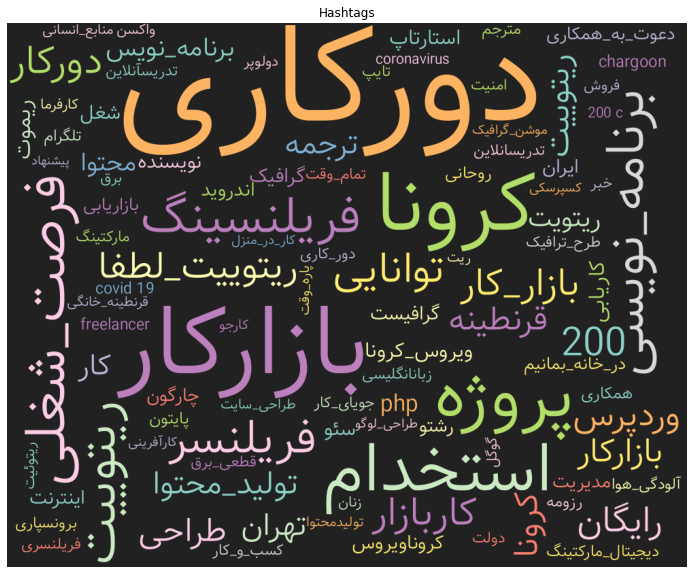

In [23]:
plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=200,
                 width=1000, 
                 height=800)
wc.generate(" ".join(hashtag_words))
plt.gca().imshow(wc)
plt.gca().set_title('Hashtags', fontdict=dict(size=12))
plt.gca().axis('off')

# Tweets

In [22]:
def get_uni_bi_tri_grams(text):
    tokens = word_tokenize(text)
    
    bigrams = list(ngrams(tokens, 2)) if len(tokens) >= 2 else []
    bigram_tokens = [' '.join(b) for b in bigrams]
    
    trigrams = list(ngrams(tokens, 3)) if len(tokens) >= 3 else []
    trigram_tokens = [' '.join(t) for t in trigrams]
    
    tokens = tokens + bigram_tokens + trigram_tokens
    return tokens

In [23]:
def get_listof_all_tweet_tokens(data_df, col_name):
    col_n_grams = data_df[col_name].progress_apply(lambda t: get_uni_bi_tri_grams(t))
    all_tokens = []
    for index, value in tqdm(col_n_grams.items()):
        all_tokens.extend(value)
    
    random.shuffle(all_tokens)
    
    return all_tokens

## Lemmatized

100%|██████████████████████████████████████████████████████████████████████████| 45359/45359 [00:00<00:00, 46282.89it/s]
45359it [00:00, 1018024.49it/s]


(-0.5, 999.5, 799.5, -0.5)

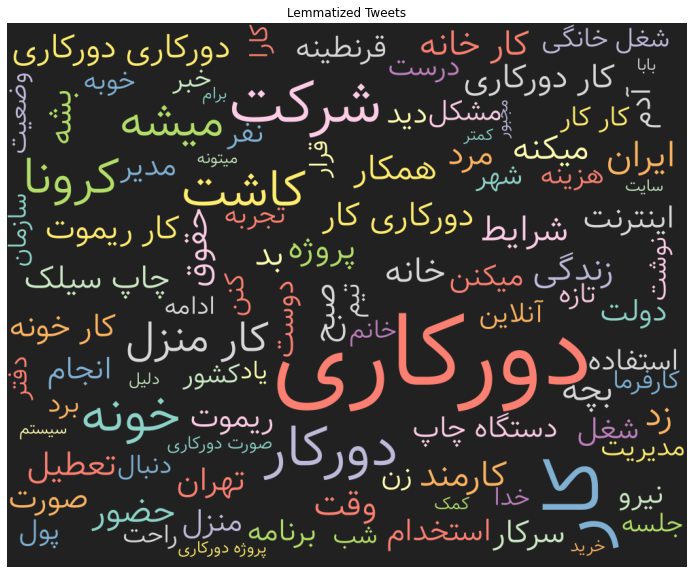

In [98]:
lemmatized_tweets_words = get_listof_all_tweet_tokens(tweets_df, 'lemmatized_tweet')

plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=150,
                 width=1000, 
                 height=800)
wc.generate(" ".join(lemmatized_tweets_words))
plt.gca().imshow(wc)
plt.gca().set_title('Lemmatized Tweets', fontdict=dict(size=12))
plt.gca().axis('off')

#### Word Frequencies

In [99]:
# Access the words and frequencies
word_frequencies = wc.words_

# Iterate over the words and print them along with their frequencies
for word, frequency in word_frequencies.items():
    print(f"Word: {word}, Frequency: {frequency}")

Word: دورکاری, Frequency: 1.0
Word: کار, Frequency: 0.5478588154171036
Word: شرکت, Frequency: 0.28318800189625204
Word: دورکار, Frequency: 0.2528623349757941
Word: خونه, Frequency: 0.20758213500739825
Word: کاشت, Frequency: 0.1979572194049791
Word: کرونا, Frequency: 0.19202424904109983
Word: میشه, Frequency: 0.1774575857263938
Word: کار منزل, Frequency: 0.1344471419746879
Word: ایران, Frequency: 0.0954590510120527
Word: کارمند, Frequency: 0.09010070247518352
Word: شرایط, Frequency: 0.08912384536926635
Word: حضور, Frequency: 0.08777348407579262
Word: همکار, Frequency: 0.08455560184453606
Word: بچه, Frequency: 0.08452687075318556
Word: زد, Frequency: 0.08419646320265475
Word: خانه, Frequency: 0.08373676574104667
Word: کار خانه, Frequency: 0.08350691701024264
Word: وقت, Frequency: 0.08046142132708911
Word: میکنه, Frequency: 0.07997299277413053
Word: بشه, Frequency: 0.07896740457686285
Word: حقوق, Frequency: 0.07883811466578558
Word: بد, Frequency: 0.07869445920903305
Word: کار دورکاری, Fr

#### English Wordcloud

In [100]:
translate_dict = {}
for word, frequency in wc.words_.items():
    translated_word = translator.translate(word)
    translate_dict[word] = translated_word
    print("word: " + word + ", translate: " + translate_dict[word])

word: دورکاری, translate: Remote
word: کار, translate: work
word: شرکت, translate: Company
word: دورکار, translate: remote work
word: خونه, translate: Home Delivery
word: کاشت, translate: Planting
word: کرونا, translate: Krona
word: میشه, translate: mind if i , uh .
word: کار منزل, translate: home work
word: ایران, translate: Iran
word: کارمند, translate: Clerk
word: شرایط, translate: Terms
word: حضور, translate: Being There
word: همکار, translate: Partner
word: بچه, translate: Child
word: زد, translate: hit
word: خانه, translate: Home
word: کار خانه, translate: factory
word: وقت, translate: When
word: میکنه, translate: does
word: بشه, translate: Be it
word: حقوق, translate: Jurisprudence
word: بد, translate: Poor
word: کار دورکاری, translate: remote work
word: دورکاری دورکاری, translate: Telecommuting Telecommuting
word: زندگی, translate: Life 
word: دورکاری کار, translate: telecommuting work
word: تعطیل, translate: Day Off!
word: پروژه, translate: Project
word: مرد, translate: Male
w

* word: دورکاری - Remote Work
^ word: کار - work
^ word: شرکت - Company
^ word: دورکار - remote work
* word: خونه - Home
^ word: کاشت - Planting
* word: کرونا - Coronavirus
* word: میشه - 
* word: کار منزل - Work from home
^ word: ایران - Iran
* word: کارمند - Employee
^ word: شرایط - Terms
^ word: حضور - Being There
^ word: همکار - Partner
^ word: بچه - Child
^ word: زد - hit
^ word: خانه - Home
^ word: کار خانه - factory
* word: وقت - Time
^ word: میکنه - does
^ word: بشه - Be it
* word: حقوق - Salary
^ word: بد - Poor
^ word: کار دورکاری - remote work
* word: دورکاری دورکاری - 
^ word: زندگی - Life 
^ word: دورکاری کار - telecommuting work
^ word: تعطیل - Day Off!
^ word: پروژه - Project
^ word: مرد - Male
^ word: کار ریموت - remote work
^ word: تهران - Tehran
^ word: چاپ سیلک - Silk print
^ word: صبح - Morning
* word: سرکار - At Work
^ word: کار خونه - housework
* word: صورت - 
^ word: اینترنت - Internet
* word: ریموت - Remote
* word: منزل - Home
^ word: مدیر - administrator
^ word

(-0.5, 999.5, 799.5, -0.5)

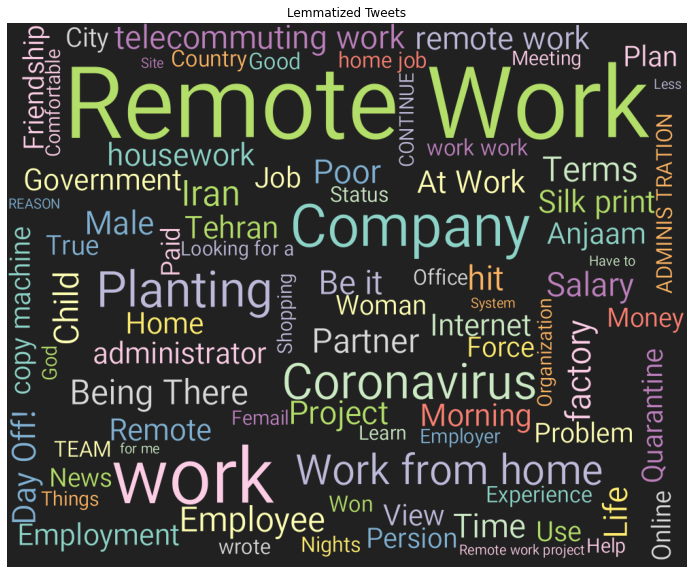

In [101]:
manual_dict = {
    "دورکاری": "Remote Work",
    "خونه": "Home",
    "کرونا": "Coronavirus",
    "کارا": "Things",
    "بابا": "",
    "سیستم": "System",
    "مجبور": "Have to",
    "یاد": "Learn",
    "تازه": "",
    "خوبه": "Good",
    "سرکار": "At Work",
    "زن": "Woman",
    "قرنطینه": "Quarantine",
    "کارمند": "Employee",
    "کارفرما": "Employer",
    "کار منزل": "Work from home",
    "صورت": "",
    "میشه": "",
    "آدم": "",
    "صورت دورکاری": "",
    "وقت": "Time",
    "تجربه": "Experience",
    "خانم": "Femail",
    "حقوق": "Salary",
    "میشه": "",
    "دورکاری دورکاری": "",
    "ریموت": "Remote",
    "میکنن": "",
    "منزل": "Home",
    "میتونه": ""
}
word_frequencies = {}
for word, frequency in wc.words_.items():
    try:
        if(word in manual_dict):
            word_frequencies[manual_dict[word]] = frequency
            print("* word: "+word+" - "+manual_dict[word])
        else:
            word_frequencies[translate_dict[word]] = frequency
            print("^ word: "+word+" - "+translate_dict[word])
            
    except Exception as e:
        print(f"Translation failed for word: {word}. Error: {e}")

plt.figure(figsize=(20,10))
wc.generate_from_frequencies(word_frequencies)
plt.gca().imshow(wc)
plt.gca().set_title('Lemmatized Tweets', fontdict=dict(size=12))
plt.gca().axis('off')

In [ ]:
# Access the words and frequencies
word_frequencies = wc.words_

# Iterate over the words and print them along with their frequencies
for word, frequency in word_frequencies.items():
    print(f"Word: {word}, Frequency: {frequency}")

## Non-Lemmatized

100%|██████████████████████████████████████████████████████████████████████████| 45359/45359 [00:02<00:00, 18777.00it/s]
45359it [00:00, 596621.39it/s]


(-0.5, 999.5, 799.5, -0.5)

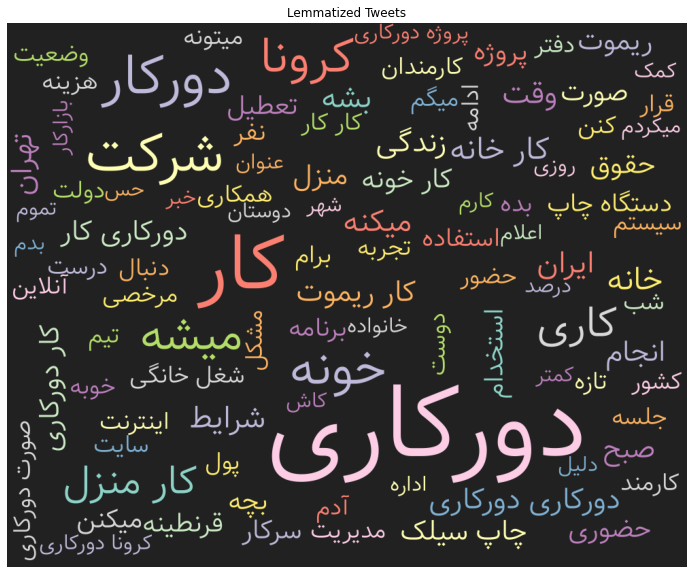

In [27]:
non_lemmatized_tweets_words = get_listof_all_tweet_tokens(tweets_df, 'tweet')

plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=150,
                 width=1000, 
                 height=800)
wc.generate(" ".join(non_lemmatized_tweets_words))
plt.gca().imshow(wc)
plt.gca().set_title('Non-Lemmatized Tweets', fontdict=dict(size=12))
plt.gca().axis('off')

In [28]:
tweets_df["tweet"].head(10)

0    گزارش حقوقش میدونم سالی ۸۵ همسرش دانشجو دکترا شرکت احتمالن مشاور مورگج براش مدارک حقوق دریافتی درست درخواست وام ۹۵۰ تاییش قبول ریسکش جالب مطمینه قراردادش تمدید میشه کار خونه ادامه میکنه
1                                                                                                                        اینایی سفر مهمونی پروتکلی رعایت نکردن سرکار خطرناکه دورکار بشیم بهتره
2            خسته دورکاری شهرهای سروصدا شب ازصبح آزاردهنده تره نبودفرهنگ شهرنشینی آپارتمان نشینی بیداد میکنه همگی رعایت همدیگر چاردیواری اختیاری مردمداری گوشه ازفرهنگ وشعور وانسانیته شب خوش🌃
3                                                                                                                                                                               آبان ۹۸ دورکار
4                                                                                                   حتمن میرفتم شهری اقوام دوستام نزدیکتر خونه اجازه میکردم فرصت کار منزل صورت ممکنه تکرار نشه
5                                            

In [30]:
base_path = "../data/"
input_file = base_path + "remote_tweets.csv"

reader = pd.read_csv(input_file)
reader.head(20)

/tmp/ipykernel_736/252964057.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  reader = pd.read_csv(input_file)


,conversation_id,retweets_count,mentions,created_at,likes_count,in_reply_to_user_id,_id,source,user_id,in_reply_to_status_id,tweet,replies_count,quoted_status_id,hashtags,cashtags,urls
0,1375557622410149894,2,NaN,2021-03-26 21:23:21+00:00,111,5.720514e+08,1375559020451356674,Twitter for iPhone,572051429,1.375558e+18,به من گزارش میده حقوقش میدونم سالی ۸۵تا، همسرش هم دانشجو....خودش سال پیش دکترا گرفته و اومده شرکت ما...احتمالن مشاور مورگج براش مدارک حقوق دریافتی بالا از جایی درست کرده و درخواست وام ۹۵۰تاییش قبول شده...ریسکش جالب بود،مطمینه که قراردادش تمدید میشه و کار از خونه ادامه پیدا میکنه,3,NaN,NaN,NaN,NaN
1,1375559420176908296,3,NaN,2021-03-26 21:24:57+00:00,163,NaN,1375559420176908296,Twitter for iPhone,812764546012246017,NaN,اینایی که رفتن سفر، مهمونی و... هیچ پروتکلی هم رعایت نکردن، فردا میان سرکار میگن خطرناکه و دورکار بشیم بهتره :)),1,NaN,NaN,NaN,NaN
2,1383828354197979136,2,NaN,2021-04-18 17:02:44+00:00,37,NaN,1383828354197979136,Twitter for Android,985101690536898565,NaN,دارم فکر میکنم که چقدر خسته ام با اینکه امروز دورکاری داشتم.تو شهرهای بزرگ سروصدا شب ازصبح آزاردهنده تره.متاسفانه نبودفرهنگ شهرنشینی و آپارتمان نشینی بیداد میکنه. بیاید همگی رعایت حال همدیگر رو بکنیم.چاردیواری اختیاری است!بله!اما مردمداری گوشه ای ازفرهنگ وشعور وانسانیته!شب خوش🌃 https://t.co/rEQ08FtHm3,3,NaN,NaN,NaN,NaN
3,1383840315031781385,0,NaN,2021-04-18 17:50:16+00:00,11,NaN,1383840315031781385,Twitter Web App,310871673,NaN,یک سال و نیمه از قبل آبان ۹۸ دورکار شدم تا الان,1,1.383657e+18,NaN,NaN,NaN
4,1383820625354002439,1,['15782990'],2021-04-18 17:31:42+00:00,9,1.578299e+07,1383835643239747593,Twitter Web App,1271095835028307969,1.383821e+18,@shahrzaad حتمن میرفتم به شهری که به اقوام یا دوستام نزدیکتر بودم و یه خونه اجازه میکردم. فرصت کار از منزل به این صورت ممکنه تکرار نشه,1,NaN,NaN,NaN,NaN
5,1383830770125443083,0,NaN,2021-04-18 17:12:20+00:00,8,NaN,1383830770125443083,Twitter Web App,897798038563033088,NaN,دورکاری یا کار از خونه خیلی برام فرسایشی شده دیگه. نیاز دارم تو محیط کاری باشم، با آدما در ارتباط باشم. افسرده شدم دیگه. برنامه نویسا رو اینطوری نگاه نکنید، سرکار خیلی خوش میگذره :(,2,NaN,NaN,NaN,NaN
6,1381125763672461313,0,['1356685682576613378'],2021-04-16 07:20:49+00:00,1,1.356686e+18,1382957135315763200,Twitter for Android,960981847814569985,1.382378e+18,@ehsan_bz تو بخش‌های دیگه نمی‌دونم ولی بخش فنی اینطور نیست. صرفا دورکاری جانیفتاده. دوست دارن حضور داشته باشیم:)))),1,NaN,NaN,NaN,NaN
7,1382520237359308801,0,"['1133806003949117441', '1200090978566230016']",2021-04-16 07:23:26+00:00,3,1.133806e+18,1382957792726777860,Twitter for Android,1199765908115329024,1.382697e+18,@Klaus5566 @sara90059240 مای بدبخت هیچوقت دورکاری نداشتیم.من کرونا گرفتم فقط چند روز بهم مرخصی دادن.هیشکی حق نداشت بگه من مریضم.تازه بعدش ک مرخصی تموم شد چند روز از این ساختمون باون ساختمون که بیمه ایام مریضیتو با کسر دویست سیصد تومن بهت بدن,2,NaN,NaN,NaN,NaN
8,1382908294826692609,0,"['1215875512045838337', '1240664911']",2021-04-16 07:15:38+00:00,22,1.215876e+18,1382955827905052673,Twitter for Android,1215875591091687424,1.382937e+18,"@JabbariForouq @Steppenwolf1989 اخه مشکل عدم همکاری محل کار با این افراده، مرخصی نمیدن و همکارا ناچار به حضورند حتی با اینکه دستور دورکاری ابلاغ شده ولی خب اجرا نمیشه عملا"" . مقصر این سیستمه که نه تعطیل می کنه نه واکسن میخره نه نظارت دقیق رو دستورالعملهای دورکاری داره",1,NaN,NaN,NaN,NaN
9,1379296978895523840,0,NaN,2021-04-06 04:56:40+00:00,8,NaN,1379296978895523840,Twitter for Android,348941511,NaN,من ترجیح میدم از #کرونا بمیرم تا از #دورکاری... #واکسن,1,NaN,"['کرونا', 'دورکاری', 'واکسن']",NaN,NaN


In [31]:
reader.head(20)

,conversation_id,retweets_count,mentions,created_at,likes_count,in_reply_to_user_id,_id,source,user_id,in_reply_to_status_id,tweet,replies_count,quoted_status_id,hashtags,cashtags,urls
0,1375557622410149894,2,NaN,2021-03-26 21:23:21+00:00,111,5.720514e+08,1375559020451356674,Twitter for iPhone,572051429,1.375558e+18,به من گزارش میده حقوقش میدونم سالی ۸۵تا، همسرش هم دانشجو....خودش سال پیش دکترا گرفته و اومده شرکت ما...احتمالن مشاور مورگج براش مدارک حقوق دریافتی بالا از جایی درست کرده و درخواست وام ۹۵۰تاییش قبول شده...ریسکش جالب بود،مطمینه که قراردادش تمدید میشه و کار از خونه ادامه پیدا میکنه,3,NaN,NaN,NaN,NaN
1,1375559420176908296,3,NaN,2021-03-26 21:24:57+00:00,163,NaN,1375559420176908296,Twitter for iPhone,812764546012246017,NaN,اینایی که رفتن سفر، مهمونی و... هیچ پروتکلی هم رعایت نکردن، فردا میان سرکار میگن خطرناکه و دورکار بشیم بهتره :)),1,NaN,NaN,NaN,NaN
2,1383828354197979136,2,NaN,2021-04-18 17:02:44+00:00,37,NaN,1383828354197979136,Twitter for Android,985101690536898565,NaN,دارم فکر میکنم که چقدر خسته ام با اینکه امروز دورکاری داشتم.تو شهرهای بزرگ سروصدا شب ازصبح آزاردهنده تره.متاسفانه نبودفرهنگ شهرنشینی و آپارتمان نشینی بیداد میکنه. بیاید همگی رعایت حال همدیگر رو بکنیم.چاردیواری اختیاری است!بله!اما مردمداری گوشه ای ازفرهنگ وشعور وانسانیته!شب خوش🌃 https://t.co/rEQ08FtHm3,3,NaN,NaN,NaN,NaN
3,1383840315031781385,0,NaN,2021-04-18 17:50:16+00:00,11,NaN,1383840315031781385,Twitter Web App,310871673,NaN,یک سال و نیمه از قبل آبان ۹۸ دورکار شدم تا الان,1,1.383657e+18,NaN,NaN,NaN
4,1383820625354002439,1,['15782990'],2021-04-18 17:31:42+00:00,9,1.578299e+07,1383835643239747593,Twitter Web App,1271095835028307969,1.383821e+18,@shahrzaad حتمن میرفتم به شهری که به اقوام یا دوستام نزدیکتر بودم و یه خونه اجازه میکردم. فرصت کار از منزل به این صورت ممکنه تکرار نشه,1,NaN,NaN,NaN,NaN
5,1383830770125443083,0,NaN,2021-04-18 17:12:20+00:00,8,NaN,1383830770125443083,Twitter Web App,897798038563033088,NaN,دورکاری یا کار از خونه خیلی برام فرسایشی شده دیگه. نیاز دارم تو محیط کاری باشم، با آدما در ارتباط باشم. افسرده شدم دیگه. برنامه نویسا رو اینطوری نگاه نکنید، سرکار خیلی خوش میگذره :(,2,NaN,NaN,NaN,NaN
6,1381125763672461313,0,['1356685682576613378'],2021-04-16 07:20:49+00:00,1,1.356686e+18,1382957135315763200,Twitter for Android,960981847814569985,1.382378e+18,@ehsan_bz تو بخش‌های دیگه نمی‌دونم ولی بخش فنی اینطور نیست. صرفا دورکاری جانیفتاده. دوست دارن حضور داشته باشیم:)))),1,NaN,NaN,NaN,NaN
7,1382520237359308801,0,"['1133806003949117441', '1200090978566230016']",2021-04-16 07:23:26+00:00,3,1.133806e+18,1382957792726777860,Twitter for Android,1199765908115329024,1.382697e+18,@Klaus5566 @sara90059240 مای بدبخت هیچوقت دورکاری نداشتیم.من کرونا گرفتم فقط چند روز بهم مرخصی دادن.هیشکی حق نداشت بگه من مریضم.تازه بعدش ک مرخصی تموم شد چند روز از این ساختمون باون ساختمون که بیمه ایام مریضیتو با کسر دویست سیصد تومن بهت بدن,2,NaN,NaN,NaN,NaN
8,1382908294826692609,0,"['1215875512045838337', '1240664911']",2021-04-16 07:15:38+00:00,22,1.215876e+18,1382955827905052673,Twitter for Android,1215875591091687424,1.382937e+18,"@JabbariForouq @Steppenwolf1989 اخه مشکل عدم همکاری محل کار با این افراده، مرخصی نمیدن و همکارا ناچار به حضورند حتی با اینکه دستور دورکاری ابلاغ شده ولی خب اجرا نمیشه عملا"" . مقصر این سیستمه که نه تعطیل می کنه نه واکسن میخره نه نظارت دقیق رو دستورالعملهای دورکاری داره",1,NaN,NaN,NaN,NaN
9,1379296978895523840,0,NaN,2021-04-06 04:56:40+00:00,8,NaN,1379296978895523840,Twitter for Android,348941511,NaN,من ترجیح میدم از #کرونا بمیرم تا از #دورکاری... #واکسن,1,NaN,"['کرونا', 'دورکاری', 'واکسن']",NaN,NaN


In [32]:
reader.drop("hashtags", axis=1, inplace=True)
reader.drop("tweet", axis=1, inplace=True)
reader

,conversation_id,retweets_count,mentions,created_at,likes_count,in_reply_to_user_id,_id,source,user_id,in_reply_to_status_id,replies_count,quoted_status_id,cashtags,urls
0,1375557622410149894,2,NaN,2021-03-26 21:23:21+00:00,111,5.720514e+08,1375559020451356674,Twitter for iPhone,572051429,1.375558e+18,3,NaN,NaN,NaN
1,1375559420176908296,3,NaN,2021-03-26 21:24:57+00:00,163,NaN,1375559420176908296,Twitter for iPhone,812764546012246017,NaN,1,NaN,NaN,NaN
2,1383828354197979136,2,NaN,2021-04-18 17:02:44+00:00,37,NaN,1383828354197979136,Twitter for Android,985101690536898565,NaN,3,NaN,NaN,NaN
3,1383840315031781385,0,NaN,2021-04-18 17:50:16+00:00,11,NaN,1383840315031781385,Twitter Web App,310871673,NaN,1,1.383657e+18,NaN,NaN
4,1383820625354002439,1,['15782990'],2021-04-18 17:31:42+00:00,9,1.578299e+07,1383835643239747593,Twitter Web App,1271095835028307969,1.383821e+18,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45354,1434127275587428352,0,['1273546506012897281'],2021-09-04 12:46:01+00:00,3,1.273547e+18,1434135662396018689,Twitter for Android,1260775960267444225,1.434127e+18,0,NaN,NaN,NaN
45355,1434127961943326723,0,['1251428296589488129'],2021-09-04 12:21:54+00:00,2,1.251428e+18,1434129593036939267,Twitter for Android,1214804130096668672,1.434128e+18,1,NaN,NaN,NaN
45356,1434138057071112194,0,NaN,2021-09-04 12:55:32+00:00,4,NaN,1434138057071112194,Twitter for iPhone,1147481863138811905,NaN,0,NaN,NaN,NaN
45357,1434133064750338048,0,NaN,2021-09-04 12:35:42+00:00,18,NaN,1434133064750338048,Twitter for Android,1106832761216815104,NaN,0,NaN,NaN,NaN


In [33]:
preprocessed_df = pd.concat([reader, tweets_df[['tweet', 'hashtags', 'tweet_tokens', 'lemmatized_tweet', 'lemmatized_tweet_token', 'tweet_size', 'lemmatized_tweet_size']]], axis = 1)

In [34]:
# pd.set_option('display.max_rows', 1000)
with pd.option_context('display.max_rows', None, ):
    print(preprocessed_df["tweet"].head(20))

0     گزارش حقوقش میدونم سالی ۸۵ همسرش دانشجو دکترا شرکت احتمالن مشاور مورگج براش مدارک حقوق دریافتی درست درخواست وام ۹۵۰ تاییش قبول ریسکش جالب مطمینه قراردادش تمدید میشه کار خونه ادامه میکنه
1                                                                                                                         اینایی سفر مهمونی پروتکلی رعایت نکردن سرکار خطرناکه دورکار بشیم بهتره
2             خسته دورکاری شهرهای سروصدا شب ازصبح آزاردهنده تره نبودفرهنگ شهرنشینی آپارتمان نشینی بیداد میکنه همگی رعایت همدیگر چاردیواری اختیاری مردمداری گوشه ازفرهنگ وشعور وانسانیته شب خوش🌃
3                                                                                                                                                                                آبان ۹۸ دورکار
4                                                                                                    حتمن میرفتم شهری اقوام دوستام نزدیکتر خونه اجازه میکردم فرصت کار منزل صورت ممکنه تکرار نشه
5                                       

In [35]:
preprocessed_df.to_csv('../data/preprocessed.csv', index=False)